# Detect AI generated text using Naive Bayes Classification

Import required libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
training_data = pd.read_csv('train_essays.csv')
training_data

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1383,86hfhd2,1,I am writing to express my perspective on the ...,1
1384,970wesgs,1,I hope this letter finds you well. I am writin...,1
1385,9831fsdga1,1,I trust this letter reaches you in good health...,1
1386,983495erg,1,I hope this letter reaches you in good health ...,1


In [3]:
prompt_data = pd.read_csv('train_prompts.csv')
prompt_data.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [4]:
testing_data = pd.read_csv('test_essays.csv')
testing_data

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.
3,3452ffdsdd,5,I trust this letter finds you well and engaged...


In [20]:
### HYPER PARAMETERS ###
vocabulary = ['in','is','and','me','I','has','you','he','she','will','was','should','him','her','themselves','or','but','not','shall','would','it','between']
min_freq_threshold = 4

In [21]:
def word_probability(essay):
    words = nltk.word_tokenize(essay)
    frequency_distribution = nltk.FreqDist(words)
    probability_dict={}
    for word in vocabulary:
        probability_dict[word] = [frequency_distribution[word]]

    #tagged_words = nltk.pos_tag(words)
    #errors = [word for word, tag in tagged_words if tag == 'VBZ' or tag == 'VBP']
    ### return human error probability ###
    return probability_dict

In [22]:
def convert_essays_to_frequency(df):
    prob_df = pd.DataFrame(columns=vocabulary)
    prob_df['id']=0
    training =(True if 'generated' in list(df.columns) else False)
    
    for index,row in df.iterrows():
        P = word_probability(row['text']) 
        P['id']=row['id']
        if training: 
            P['generated'] = int(row['generated'])
        prob_df = pd.concat([prob_df,pd.DataFrame(P)],ignore_index=True)
    return prob_df

In [23]:
freq_dt = convert_essays_to_frequency(training_data)

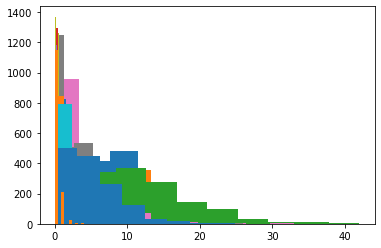

In [24]:
for i in freq_dt.columns:
    if i !='id' and i != 'generated':
        plt.hist(freq_dt[i])

In [59]:
class NBC:
    def __init__(self,data,min_threshold):
        
        words = {}
        words_dep = {}
        for index,row in data.iterrows():
            ws = nltk.word_tokenize(row['text'])
            word_freq = nltk.FreqDist(ws)
            #word_freq = convert_essay_to_freq(row['essay'])
            for key,val in word_freq.items():
                if key in words.keys():words[key]+=1
                else:words[key]=1
                if key in words_dep.keys() and row['generated']:words_dep[key]+=1
                else:words_dep[key]=0
        self.__threshold = min_threshold        
        self.__pw = {}
        self.__pwg = {}
        self.__pg = len(data[data['generated']==1])/ len(data)
        for key,val in words.items():
            self.__pw[key] = val/len(data)
            self.__pwg[key] = words_dep[key]/len(data[data['generated']==1])
    def predict(self,essay):
        ws = nltk.word_tokenize(row['text'])
        word_freq = nltk.FreqDist(ws)
        
        pw = 1
        pwg = 1
        for key,val in word_freq.items():
            if val >= self.__threshold:
                if key in self.__pw.keys() and key in self.__pwg.keys():
                    pw *= self.__pw[key]
                    pwg*= self.__pwg[key]
                else:
                    pw*=0
                    pwg*=0
        return (pw*self.__pg)/pwg

In [60]:
model = NBC(training_data,5)

In [63]:
final_dt = pd.DataFrame([],columns=['id','generated'])
for index,row in testing_data.iterrows():
    final_dt.loc[len(final_dt)]={'id':row['id'],'generated':model.predict(row['text'])}
final_dt.head()

,id,generated
0,0000aaaa,0.0093659942
1,1111bbbb,0.0093659942
2,2222cccc,0.0093659942
3,3452ffdsdd,0.0506475395


In [64]:
final_dt.to_csv('submission.csv',index=False)